In [1]:
import torch, os, glob
import torch.nn.functional as F
from PIL import Image
from model_utils import Classification_Model
from image_utils import load_rgb_mean_std, apply_transforms_crops, show_attr
from generate_page_mask import generate_page_mask
from extract_image_crops import extract_image_crops
from tqdm import tqdm
from captum.attr import Lime
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearRegression
import matplotlib.pyplot as plt

# Phase 1 -> Model Loading

In [2]:
CWD = os.getcwd()
root = CWD + "/./../classifier_NN"
cp_base = root + "/cp/Test_3_TL_val_best_model.pth"
cp = root + "/tests/output/VatLat653/checkpoints/Test_VatLat653_MLC_val_best_model.pth"

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("Device: CPU")

Device: NVIDIA GeForce RTX 3060


In [4]:
num_classes = len(os.listdir(root + "/tests/output/VatLat653/test"))
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=cp_base).to(DEVICE)
model.load_state_dict(torch.load(cp)['model_state_dict'])
model.eval()

Classification_Model(
  (base_model): BaseModel(
    (enc): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

# Phase 2 -> LIME Set-Up

In [5]:
mean, std = load_rgb_mean_std(root + "/tests/output/VatLat653/train")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: [0.7480102365900069, 0.68539503481047, 0.6106940184064141]
Standard Deviation: [0.12103176623548548, 0.12333822199809806, 0.12341452994910058]


In [6]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

In [7]:
lr_lime = Lime(
    model,
    interpretable_model=SkLearnLinearRegression(),
    similarity_func=exp_eucl_distance
)

# Phase 3 -> Instance-to-Explain Loading, Mask Creation & Crop Creation

In [8]:
img_name = "Vat.lat.653_0011_fr_0001r_m"

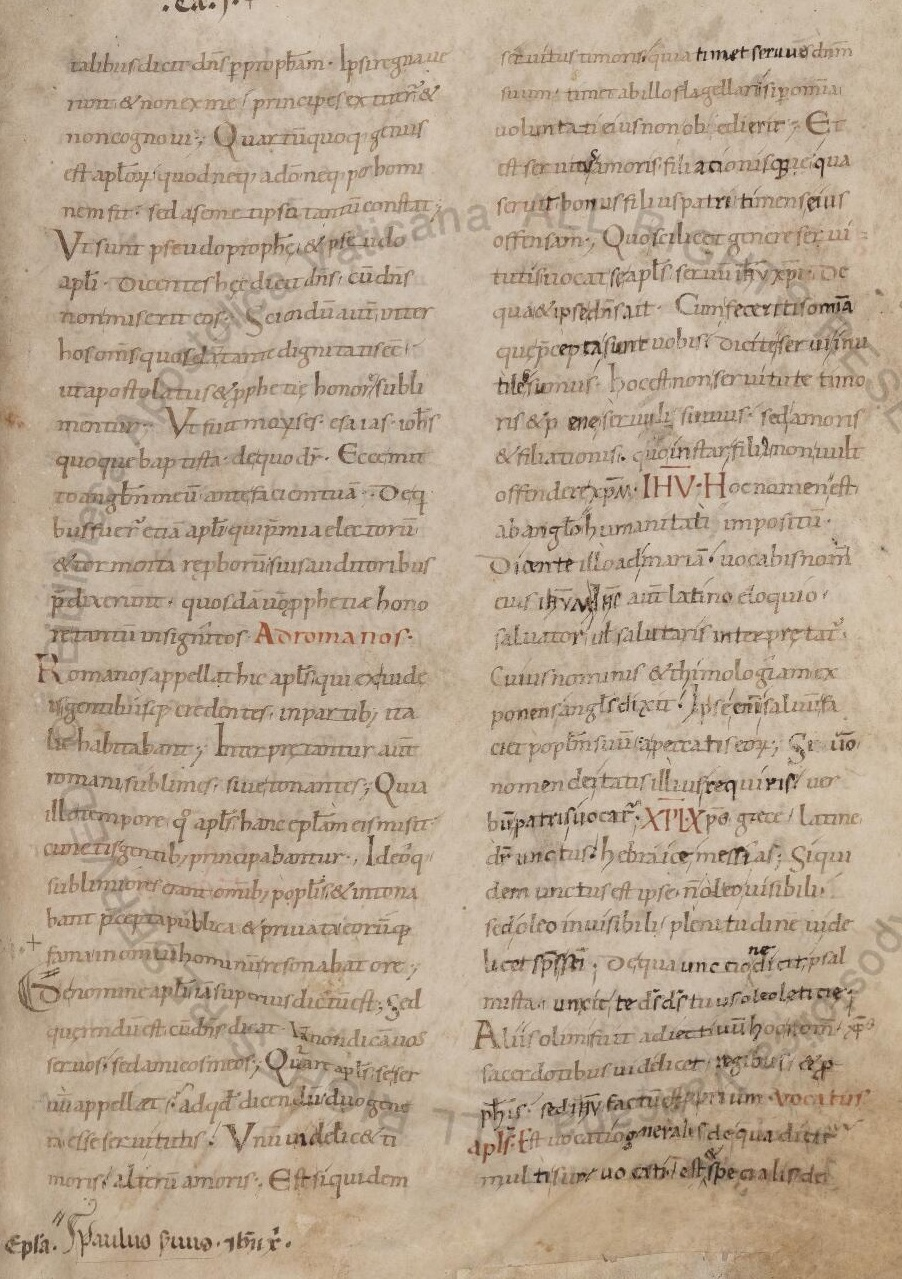

In [9]:
img_path = "/tests/output/VatLat653/test/0/" + img_name
if not os.path.exists(f"./explanations/crop_level/{img_name}"):
    os.makedirs(f"./explanations/crop_level/{img_name}")

img = Image.open(root + img_path + ".jpg")
img

In [10]:
if not os.path.exists(f"./data/{img_name}.jpg"):
    os.system(f"cp {root + img_path}.jpg ./data/{img_name}.jpg")

block_height, block_width = 50, 50
generate_page_mask(file_name=img_name, block_height=block_height, block_width=block_width)

os.system(f"mv ./data/{img_name}/{img_name}_mask_blocks_{block_width}x{block_height}.png ./explanations/crop_level/{img_name}/{img_name}_mask_blocks_{block_width}x{block_height}.png")
os.system(f"rm -r ./data/{img_name}")

Original Image Size: 902x1279 pixels
Mask Image Size: 902x1279 pixels


0

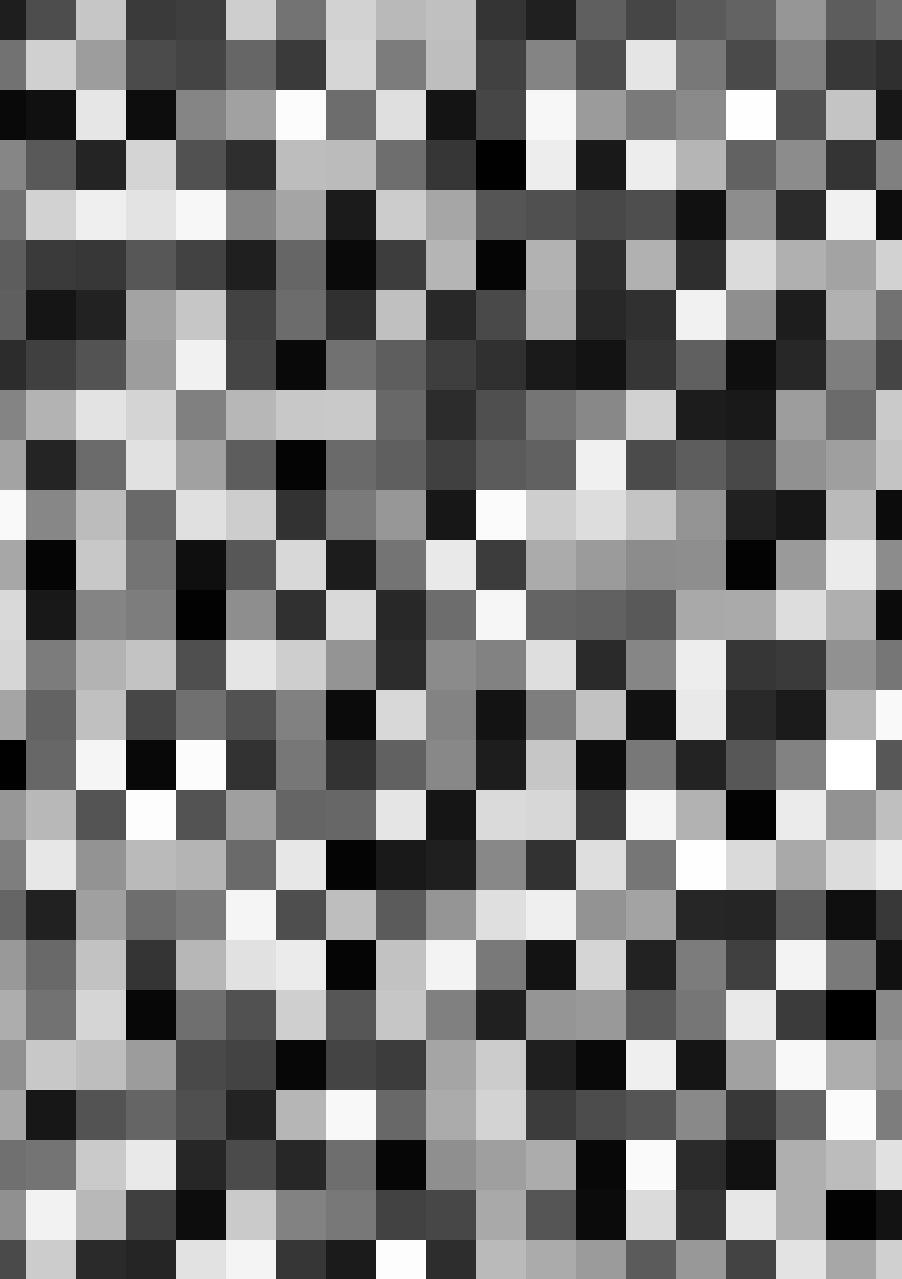

In [11]:
mask = Image.open(f"./explanations/crop_level/{img_name}/{img_name}_mask_blocks_{block_width}x{block_width}.png")
mask

In [12]:
extract_image_crops(img_name, block_width, block_height, crop_size=380, overlap=180)

# Phase 4 -> LIME Execution

In [13]:
output_name = f"./explanations/crop_level/{img_name}"
img_paths = glob.glob(os.path.join(f"./explanations/crop_level/{img_name}/crops", "*.jpg"))
mask_paths = glob.glob(os.path.join(f"./explanations/crop_level/{img_name}/crops", "*.png"))

with open(f"{output_name}/crop_classification_report.txt", "w") as f:
    f.write("CROP\t PREDICTED CLASS\t CONFIDENCE\n")

In [14]:
for img_path, mask_path in tqdm(zip(img_paths, mask_paths)):
    img, mask = Image.open(img_path), Image.open(mask_path)
    img, mask, n_interpret_features = apply_transforms_crops(img, mask, mean, std)

    img, mask = img.to(DEVICE), mask.to(DEVICE)

    input_ = img.unsqueeze(0)
    feature_mask = mask.unsqueeze(0)

    outputs = model(input_)
    output_probs = F.softmax(outputs, dim=1)[0].squeeze()
    label_idx = output_probs.argmax().unsqueeze(0)

    with open(f"{output_name}/crop_classification_report.txt", "a") as f:
        f.write(f"{os.path.basename(img_path)}\t {label_idx.item()}\t {output_probs[label_idx].item()}\n")
    
    attrs = lr_lime.attribute(
        inputs=input_,
        target=label_idx,
        feature_mask=feature_mask,
        n_samples=100,
        perturbations_per_eval=16,
        show_progress=False
    ).squeeze(0)

    dest_path_attr_heat_map = f"{img_path[:-4]}"
    show_attr(attrs, dest_path_attr_heat_map)

plt.close()

15it [00:06,  2.32it/s]
